In [448]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.gaussian_process as gp
from scipy.stats import multivariate_normal
from matplotlib import cm
from scipy.stats import norm
from scipy.special import erf
from scipy.optimize import minimize
from scipy.special import logsumexp
import jax
import jax.numpy as jnp
import time

## MC Integration

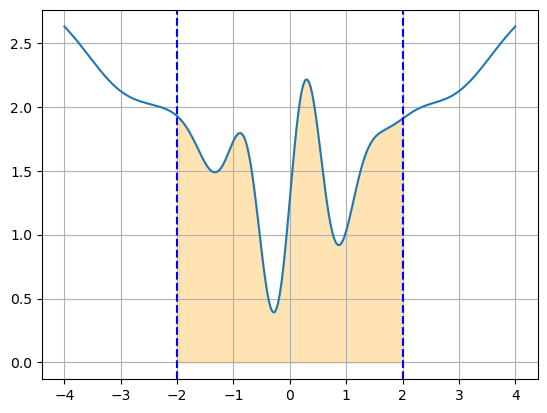

True value: 5.96051236421104

Normal Monte Carlo:
Value: 5.976776, Absolute Error: 0.016263, StDev:0.055921

Monte Carlo with Antithetic Variables:
Value: 6.000523, Absolute Error: 0.040010, StDev:0.026324


In [449]:
def f(x):
    return jnp.exp(-x**2)*jnp.sin(5*x) + jnp.log(1 + x**2)/(1 + x**4) + (x**2 + jnp.cos(3*x) + 1.1)**(1/3)

lower = -2
upper = 2
interval = upper - lower

points = np.linspace(lower-0.5*interval,upper+0.5*interval,250)
y = f(points)

mask = (points >= lower) & (points <= upper)
points_fill = points[mask]
y_fill = y[mask]

plt.plot(points,y)
plt.axvline(lower, color='b', linestyle='--',)
plt.axvline(upper, color='b', linestyle='--',)
plt.fill_between(points_fill, y_fill, color='orange', alpha=0.3) 
plt.grid()
plt.show()

n = 1000
true_value = 5.96051236421104

#Normal MC
x = np.random.uniform(0,1,n)
x1 = lower + x*interval
mc = jnp.mean(f(x1))*interval
error1 = np.abs(true_value - mc)
StDev1 = np.sqrt(np.var(f(x1))/n)*interval

n = 1000
#MC with Antithetic Variables
x = 1 - x
x2 = lower + x*interval
mc_at = (0.5*np.mean(f(x1)) + 0.5*np.mean(f(x2)))*interval
error2 = np.abs(true_value - mc_at)
StDev2 = np.sqrt(np.var(0.5*f(x1) + 0.5*f(x2))/n)*interval

print(f"True value: {true_value}")
print()
print("Normal Monte Carlo:")
print(f"Value: {mc:.6f}, Absolute Error: {error1:.6f}, StDev:{StDev1:.6f}")
print()
print("Monte Carlo with Antithetic Variables:")
print(f"Value: {mc_at:.6f}, Absolute Error: {error2:.6f}, StDev:{StDev2:.6f}")

## Gaussian Process

<div class="alert alert-block alert-info">

The partitioned Gaussian vector:
$$
\begin{bmatrix} \mathbf{x}_1 \\ \mathbf{x}_2 \end{bmatrix} \sim \mathcal{N}\left( \begin{bmatrix} \boldsymbol{\mu}_1 \\ \boldsymbol{\mu}_2 \end{bmatrix}, \begin{bmatrix} \Sigma_{11} & \Sigma_{12} \\ \Sigma_{21} & \Sigma_{22} \end{bmatrix} \right),
$$

$$
\boldsymbol{\mu}_{2|1} = \boldsymbol{\mu}_2 + \Sigma_{21} \Sigma_{11}^{-1} (\mathbf{x}_1 - \boldsymbol{\mu}_1),
$$
$$
\Sigma_{2|1} = \Sigma_{22} - \Sigma_{21} \Sigma_{11}^{-1} \Sigma_{12}.
$$


Let:
$$
\mathbf{x}_1 = \mathbf{f}, \quad \mathbf{x}_2 = \mathbf{f}_*, \quad \boldsymbol{\mu}_1 = \mathbf{0}, \quad \boldsymbol{\mu}_2 = \mathbf{0},
$$
$$
\Sigma_{11} = K(X, X), \quad \Sigma_{12} = K(X, X_*), \quad \Sigma_{21} = K(X_*, X), \quad \Sigma_{22} = K(X_*, X_*).
$$

Then:
$$
p\left( \begin{bmatrix} \mathbf{f} \\ \mathbf{f}_* \end{bmatrix} \middle| X, X_* \right) = \mathcal{N}\left( \begin{bmatrix} \mathbf{0} \\ \mathbf{0} \end{bmatrix}, \begin{bmatrix} K(X, X) & K(X, X_*) \\ K(X_*, X) & K(X_*, X_*) \end{bmatrix} \right),
$$

---

The posterior $\textbf{mean}$ is:
$$
\begin{aligned}
\boldsymbol{\mu}_{\mathbf{f}_* | \mathbf{f}} &= \boldsymbol{\mu}_2 + \Sigma_{21} \Sigma_{11}^{-1} (\mathbf{x}_1 - \boldsymbol{\mu}_1)\\ &= K(X_*, X) K(X, X)^{-1} \mathbf{f}.
\end{aligned}
$$

The posterior $\textbf{covariance}$ is:
$$
\begin{aligned}
\Sigma_{\mathbf{f}_* | \mathbf{f}} &= \Sigma_{22} - \Sigma_{21} \Sigma_{11}^{-1} \Sigma_{12}\\ &= K(X_*, X_*) - K(X_*, X) K(X, X)^{-1} K(X, X_*).
\end{aligned}
$$
  
</div>

#### 1D Gaussian Process

In [ ]:
def gp_predict1d(xs, ys, x_eval, kernel, s=1, l=1):
    xs = xs.reshape(-1,1)
    ys = ys.reshape(-1,1)
    x_eval = x_eval.reshape(-1,1)

    K_xx = kernel(xs, xs, s, l)
    K_xs = kernel(x_eval, xs, s, l)
    K_sx = kernel(xs, x_eval, s, l)
    K_xx_eval = kernel(x_eval, x_eval, s, l)

    L = jnp.linalg.solve(K_xx, ys)
    mu = K_xs@L
    sig = K_xx_eval - K_xs@jnp.linalg.solve(K_xx, K_sx)
    return mu.ravel(), sig + 1e-9*jnp.eye(sig.shape[0])

#Kernel 1
def rbf1d(x1, x2, s=1, l=1):
    x1 = x1.reshape(-1,1)
    x2 = x2.reshape(1,-1)
    dists = (x1 - x2)**2/(2*l**2)
    return s**2*jnp.exp(-dists)

#Kernel 2
def matern1d(x1,x2,rho=1/5):
    x1 = x1.reshape(-1,1)
    x2 = x2.reshape(1,-1)
    return (1. + np.sqrt(3.)*np.abs(x1-x2)/rho)*np.exp(-np.sqrt(3.)*np.abs(x1-x2)/rho)


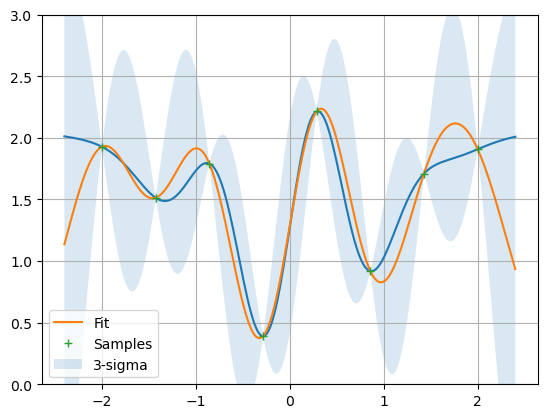

In [451]:
lower = -2
upper = 2
interval = upper - lower

points = np.linspace(lower-0.1*interval,upper+0.1*interval,250)
y = f(points)

mask = (points >= lower) & (points <= upper)
points_fill = points[mask]
y_fill = y[mask]

plt.plot(points,y)


n = 8
x = np.linspace(lower,upper,n)
y = f(x)
s = 1
l = 0.4

x_eval = np.linspace(lower-0.1*interval,upper+0.1*interval,250)
mu_eval,var_eval = gp_predict1d(x,y,x_eval,kernel=rbf1d, s=s, l=l)
sig_diag = np.sqrt(np.clip(np.diag(var_eval), 0.0, None))

plt.plot(x_eval,mu_eval,label='Fit')
plt.plot(x,y,'+',label='Samples')
plt.fill_between(x_eval,mu_eval-3*sig_diag,mu_eval+3*sig_diag,alpha=0.17,label='3-sigma')
plt.ylim(0,3)
plt.legend()
plt.grid()
plt.show()

C:\Users\gmedw\AppData\Local\Temp\ipykernel_35944\4281104191.py:3: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(mu_eval, var_eval, size=n_samples)


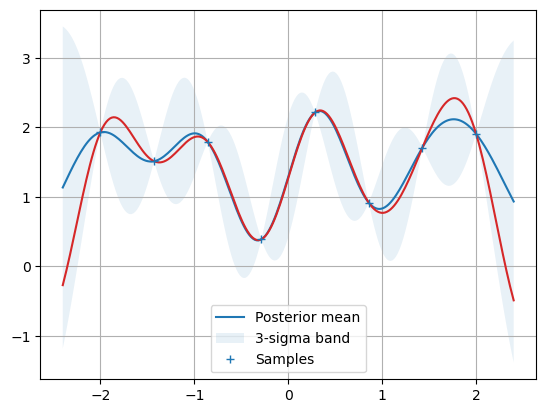

In [452]:
#sample paths of the GP posterior
n_samples = 100000
samples = np.random.multivariate_normal(mu_eval, var_eval, size=n_samples)

#use trapezoidal rule weights for integration
dx = np.diff(x_eval)
weights = np.zeros_like(x_eval)
weights[1:-1] = (dx[:-1] + dx[1:])/2
weights[0] = dx[0]/2
weights[-1] = dx[-1]/2

#compute integrals and find 1% with lowest values
integrals = samples@weights
n_bottom = int(0.01*n_samples)
bottom_idx = np.argsort(integrals)[:n_bottom]
bottom_mean_curve = samples[bottom_idx].mean(axis=0)

#plot results
plt.plot(x_eval, mu_eval, label='Posterior mean', color='C0')
std_eval = np.sqrt(np.diag(var_eval))
plt.fill_between(
    x_eval,
    mu_eval - 3 * std_eval,
    mu_eval + 3 * std_eval,
    alpha=0.1,
    label='3-sigma band'
)
plt.plot(x_eval, bottom_mean_curve, color='C3')
plt.plot(x,y,'+',label='Samples')
plt.legend()
plt.grid()
plt.show()

#### 2D Gaussian Process

In [578]:
def gp_predict2d(xs, ys, x_eval, kernel, l = 5, s = 5):

    ys = ys.reshape(-1,1)

    K = kernel(xs, xs, l, s) + 1e-6*np.eye(xs.shape[0])
    K_s = kernel(xs, x_eval, l, s)
    K_ss = kernel(x_eval, x_eval, l, s)


    # Predictive mean
    mu = K_s.T@np.linalg.solve(K, ys)

    # Predictive covariance
    v = np.linalg.solve(K, K_s)
    sig = K_ss - K_s.T@v

    return mu.ravel(), sig


def rbf2d(X1, X2, l=2, s=1): 
    X1 = np.atleast_2d(X1) 
    X2 = np.atleast_2d(X2) 
    
    diff = X1[:, None, :] - X2[None, :, :] 
    sqdist = np.sum(diff**2, axis=2) 
    return s**2*np.exp(-0.5/l**2*sqdist)


Relative Humidity is a function of temperature and dew point.

$$
e_s(T) = 6.1121 \, \exp\left(\left(18.678 - \frac{T}{234.5}\right) \cdot \left(\frac{T}{257.14 + T}\right)\right) \\

e = 6.1121 \, \exp\left(\left(18.678 - \frac{T_d}{234.5}\right) \cdot \left(\frac{T_d}{257.14 + T_d}\right)\right) \\
$$
$$
RH = 100 \times \frac{e}{e_s(T)}
$$

In [454]:
def RH(T, Td):
    eT = 6.1121*np.exp((18.678 - T/234.5)*(T/(257.14 + T)))
    eTd = 6.1121*np.exp((18.678 - Td/234.5)*(Td/(257.14 + Td)))
    return 100*eTd/eT


For Temp: 10.2°C and DewP: 3.3°C
--------------------------------------
Relative humidity1 is: 62.3112%
The gp estimate is: 63.1337%
Error: 0.8224
95% CI: [62.5177%, 63.7497%]



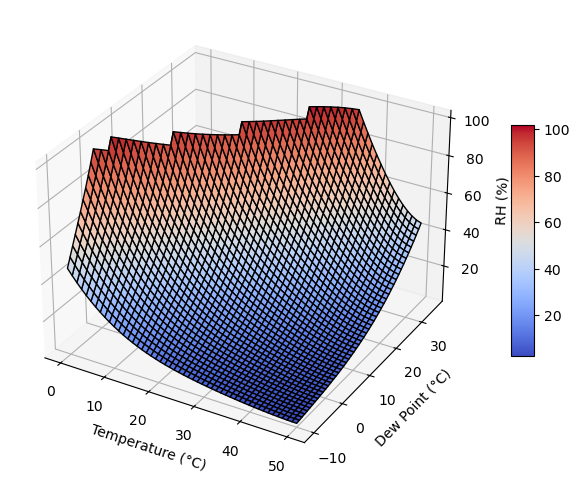

In [579]:
#training data points
Temp = np.linspace(0,50,5)
DewP = np.linspace(-10,35,4)
T, D = np.meshgrid(Temp, DewP)
TD = np.column_stack([T.ravel(), D.ravel()])
rh = RH(TD[:,0], TD[:,1])


#evaluation points
Temp_eval = np.linspace(0,50,50)
DewP_eval = np.linspace(-10,35,50)
T_eval, D_eval = np.meshgrid(Temp_eval, DewP_eval)
TD_eval = np.column_stack([T_eval.ravel(), D_eval.ravel()])


#fit GP
l = 120
s = 27000
mu_grid, var_grid = gp_predict2d(TD, rh, TD_eval, kernel=rbf2d, l=l, s=s)
mu_grid = mu_grid.reshape(T_eval.shape)
mu_grid = np.where(D_eval > T_eval, np.nan, mu_grid)


#calculate relative humidity at random point
T = np.random.uniform(0,50,1)[0]
D = np.random.uniform(-10,T,1)[0]
relhum = RH(T,D)
#predict at same random point
gp_est, gp_var = gp_predict2d(TD, rh, (T,D), kernel=rbf2d, l=l, s=s)
low = gp_est - 1.96*np.sqrt(gp_var)
high = gp_est + 1.96*np.sqrt(gp_var)
error = np.abs(relhum - gp_est)


print(f'For Temp: {T:.1f}°C and DewP: {D:.1f}°C')
print('--------------------------------------')
print(f'Relative humidity1 is: {relhum:.4f}%')
print(f'The gp estimate is: {gp_est[0]:.4f}%')

print(f'Error: {error[0]:.4f}')
print(f'95% CI: [{low[0][0]:.4f}%, {high[0][0]:.4f}%]')
print()

#plot of GP surface
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(T_eval, D_eval, mu_grid, cmap=cm.coolwarm, edgecolor='k')
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Dew Point (°C)')
ax.set_zlabel('RH (%)')
fig.colorbar(surf, shrink=0.5, aspect=10)
plt.show()


## Bayesian Quadrature 1D example
### Integrating f(t)
For a gaussian process $f \sim \mathcal{GP}(m(x), k(x, x'))$, the following:

$$
F(x) = \int_a^x f(t) dt
$$

can be expressed in closed form.

---

Lets start by deriving the mean of the integral

Using RBF Kernel $k(y,x) = \sigma_f^2\exp \left(-\frac{1}{2l^2} |x-y|^2 \right)$:
$$
\begin{aligned}
v[k] &= \int_a^x k(t,s) dt \\ 
     &= \int_a^x \sigma_f^2\exp \left(-\frac{1}{2l^2} |s-t|^2 \right) dt \\
\end{aligned}
$$
Let $l = \sigma$ hereon and factor out $\sigma_f^2 \cdot \sigma \sqrt{2\pi}$:
$$
\begin{aligned}
v[k] &= \sigma_f^2 \cdot \sigma \sqrt{2\pi} \int_a^x \frac{1}{\sigma\sqrt{2\pi}}\exp \left(-\frac{(s-t)^2}{2\sigma^2} \right) dt \\
     &= \sigma_f^2 \cdot \sigma \sqrt{2\pi} \int_a^x k^*(t,s) dt \\
\end{aligned}
$$
Now working with just $k^*(t,s)$:
$$
\begin{aligned}
v^*[k] &= \int_a^x \frac{1}{\sigma\sqrt{2\pi}}\exp \left(-\frac{(s-t)^2}{2\sigma^2} \right) dt \\
     &= \frac{1}{2} \left[1+\text{erf} \left(\frac{x-s}{\sigma\sqrt{2}} \right) \right] - \frac{1}{2} \left[1+\text{erf} \\ \left(\frac{a-s}{\sigma\sqrt{2}} \right) \right] \\
     &= \frac{1}{2} \left[ \text{erf} \left(\frac{x-s}{\sigma\sqrt{2}} \right) - \text{erf}\left(\frac{a-s}{\sigma\sqrt{2}} \right) \right] \\
\end{aligned}
$$

---

For the uncertainty we have to integrate again. 

$$
\begin{aligned}
vv[k] &= \int_a^x \int_a^x k(t,s) dsdt \\
      &= \sigma_f^2 \cdot \sigma \sqrt{2\pi} \int_a^x \int_a^x k^*(t,s) dtds \\
      &= \sigma_f^2 \cdot \sigma \sqrt{2\pi} \int_a^x \frac{1}{2}\text{erf} \left(\frac{x-s}{\sigma\sqrt{2}} \right) - \frac{1}{2}\text{erf} \left(\frac{a-s}{\sigma\sqrt{2}} \right)ds \\
\end{aligned}
$$

Focusing on just $k^*(t,s)$, let $u_1 = \frac{x-s}{\sigma\sqrt{2}}$ and $u_2 = \frac{a-s}{\sigma\sqrt{2}}$  

$\implies$ $du_1 = du_2 = du = \frac{-1}{\sigma\sqrt{2}} \cdot ds$ 

$\implies$ $ds = -\sigma\sqrt{2} \cdot du$

$$
\begin{aligned}
vv^*[k] &= \int_a^x \frac{1}{2}\text{erf}(u_1)ds - \int_a^x\frac{1}{2}\text{erf}(u_2)ds \\
       &= \int_{\frac{x-a}{\sigma\sqrt{2}}}^0 -\frac{1}{2}\text{erf}(u_1) \cdot \sigma\sqrt{2} \cdot du_1 - \int_0^{\frac{a-x}{\sigma\sqrt{2}}} - \frac{1}{2}\text{erf}(u_2) \cdot \sigma\sqrt{2} \cdot du_2 \\
       &= \int_0^{\frac{x-a}{\sigma\sqrt{2}}} \frac{1}{2}\text{erf}(u) \cdot \sigma\sqrt{2} \cdot du - \int_{\frac{a-x}{\sigma\sqrt{2}}}^0 \frac{1}{2}\text{erf}(u) \cdot \sigma\sqrt{2} \cdot du \\
       &= \frac{\sigma\sqrt{2}}{2} \left(\int_0^{\frac{x-a}{\sigma\sqrt{2}}} \text{erf}(u)du + \int_0^{\frac{x-a}{\sigma\sqrt{2}}} \text{erf}(u)du \right) \\
       &= \sigma\sqrt{2} \left(\int_0^{\frac{x-a}{\sigma\sqrt{2}}} \text{erf}(u)du \right) \\
\end{aligned}
$$

Using $\int_0^\theta \text{erf}(u)du = \theta \, \text{erf}(\theta) + \frac{e^{-\theta^2} - 1}{\sqrt{\pi}}$, Let $\theta = \frac{x-a}{\sigma\sqrt{2}}$:

$$
\begin{aligned}
vv^*[k] &= \sigma\sqrt{2} \left(\theta \, \text{erf}(\theta) + \frac{e^{-\theta^2} - 1}{\sqrt{\pi}} \right) \\
        &= (x-a) \, \text{erf} \left( \frac{x-a}{\sigma \sqrt{2}} \right) + \sigma\sqrt{2} \left( \frac{\exp{\left(-{\frac{(x-a)^2}{2 \sigma^2}}\right)} - 1}{\sqrt{\pi}} \right)\\
\end{aligned}
$$

---

So we have:
$$
\begin{align*}
v[k] &= \left( \sigma_f^2 \cdot \sigma \sqrt{2\pi} \right) v^*[k] \\
     &= \left( \sigma_f^2 \cdot \sigma \sqrt{2\pi} \right) \, \left[\frac{1}{2} \text{erf} \left(\frac{x-s}{\sigma\sqrt{2}} \right) - \frac{1}{2} \text{erf}\left(\frac{a-s}{\sigma\sqrt{2}} \right) \right] \\
     \\
vv[k] &= \left( \sigma_f^2 \cdot \sigma \sqrt{2\pi} \right) vv^*[k] \\
      &= \left( \sigma_f^2 \cdot \sigma \sqrt{2\pi} \right) \left[(x-a) \, \text{erf} \left( \frac{x-a}{\sigma \sqrt{2}} \right) + \sigma\sqrt{2} \left( \frac{\exp{\left(-{\frac{(x-a)^2}{2 \sigma^2}}\right)} - 1}{\sqrt{\pi}} \right) \right] \\
      &= \sigma_f^2 \left[ \sigma \sqrt{2\pi} \, (x-a) \, \text{erf} \left( \frac{x-a}{\sigma \sqrt{2}} \right) + 2 \sigma^2 \left( e^{-{\frac{(x-a)^2}{2 \sigma^2}}} - 1 \right) \right] \\
\end{align*}
$$



In [456]:
def vk(input,lower, upper, s=1,l=1):
    return s**2*l*np.sqrt(2*np.pi)*(0.5*erf((upper-input)/(l*np.sqrt(2))) - 0.5*erf((lower-input)/(l*np.sqrt(2))))

def vvk(lower, upper, s=1, l=1):
    return s**2*(l*np.sqrt(2*np.pi)*(upper-lower)*erf((upper-lower)/(l*np.sqrt(2))) + 2*l**2*(np.exp(-(upper-lower)**2/(2*l**2)) - 1))

def integrate_rbf1d(x_eval,y_eval, lower, upper, s=1,l=1):
    
    x_eval = x_eval.reshape(-1,1)
    y_eval = y_eval.reshape(-1,1)
    
    kxx = rbf1d(x_eval,x_eval.T,s,l)
    kxx += 1e-10 * np.eye(len(kxx))
    kxx = (kxx + kxx.T)/2
    
    kf = vk(x_eval,lower,upper,s,l)

    mu = kf.reshape(1,-1)@np.linalg.solve(kxx,y_eval)
    var = vvk(lower,upper,s,l) - kf.reshape(1,-1)@np.linalg.solve(kxx,kf.reshape(-1,1))
    var = max(var, 0.0)
    
    return mu, var

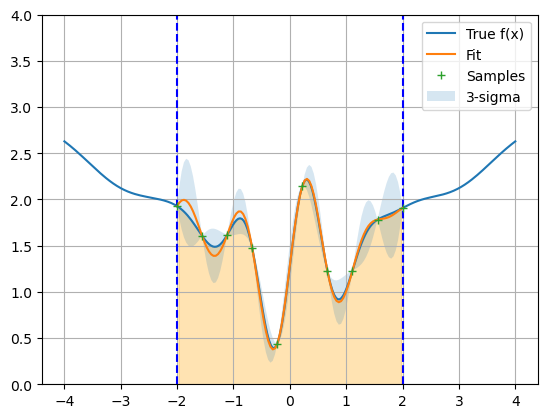

True value: 5.96051236421104

Bayesian Quadrature
2 pts:
Estimate: 2.40366540 , StDev: 3.86153254
Absolute Error: 3.55684696

4 pts:
Estimate: 5.50092005 , StDev: 1.76728512
Absolute Error: 0.45959232

6 pts:
Estimate: 6.06668794 , StDev: 0.36595123
Absolute Error: 0.10617558

10 pts:
Estimate: 5.98532493 , StDev: 0.04149750
Absolute Error: 0.02481256

15 pts:
Estimate: 5.96336145 , StDev: 0.00281094
Absolute Error: 0.00284909

50 pts:
Estimate: 5.96144878 , StDev: 0.00040038
Absolute Error: 0.00093641



In [457]:
def f(x):
    return jnp.exp(-x**2)*jnp.sin(5*x) + jnp.log(1 + x**2)/(1 + x**4) + (x**2 + jnp.cos(3*x) + 1.1)**(1/3)

lower = -2
upper = 2
interval = upper - lower

points = np.linspace(lower-0.5*interval,upper+0.5*interval,250)
y = f(points)

mask = (points >= lower) & (points <= upper)
points_fill = points[mask]
y_fill = y[mask]

plt.plot(points,y, label='True f(x)')
plt.axvline(lower, color='b', linestyle='--',)
plt.axvline(upper, color='b', linestyle='--',)
plt.fill_between(points_fill, y_fill, color='orange', alpha=0.3) 
plt.grid()

true_value = 5.96051236421104

#kernel hyperparameters
s = 2
l = 0.5
#sample n points
n = 10
x = np.linspace(lower,upper,n)
y = f(x)

#points to plot gp
x_eval = np.linspace(lower,upper,100)
mu_eval,var_eval = gp_predict1d(x,y,x_eval,kernel=rbf1d,s=s,l=l)
sig_diag = np.sqrt(np.clip(np.diag(var_eval), 0.0, None))


#plot gp
plt.plot(x_eval,mu_eval,label='Fit')
plt.plot(x,y,'+',label='Samples')
plt.ylim(0,4)
plt.fill_between(x_eval,mu_eval-3*sig_diag,mu_eval+3*sig_diag,alpha=0.18,label='3-sigma')
plt.legend()
plt.show()

print(f"True value: {true_value}")
print()
print("Bayesian Quadrature")
for n in [2,4,6,10,15,50]:
    x = np.linspace(lower,upper,n)
    y = f(x)
    I_mu, I_var = integrate_rbf1d(x,y,lower,upper,s,l)
    error = np.abs(true_value - I_mu[0][0])
    print(f"{n} pts:")
    print(f"Estimate: {I_mu[0][0]:.8f} , StDev: {np.sqrt(I_var[0][0]):.8f}")
    print(f"Absolute Error: {error:.8f}")
    print()

## Bayesian Quadrature
### Integrating f(t)p(t) - univariate case

For a gaussian process $f \sim \mathcal{GP}(m(x), k(x, x'))$ and a gaussian density $p \sim \mathcal{N}$, the following:

$$
\begin{aligned}
F(x) &= \int_a^x f(t) d\mathbb{P}(t) \\
     &= \int_a^x f(t) p(t) dt\\
\end{aligned}
$$

can be expressed in closed form.

---

**Prior mean function:**

$$
\begin{aligned}
M(x) &= \mathbb{E}[F(x)] \\
      &= \mathbb{E}\left[\int_a^x f(t)p(t) dt\right] \\
      &= \int_a^x \mathbb{E}[f(t)] p(t) dt \\
      &= \int_a^x m(t) p(t)dt
\end{aligned}
$$


**Prior covariance function:**

$$
\begin{aligned} 
K(x,x') &= \text{Cov}\Big(F(x), F(x')\Big) \\
        &= \text{Cov}\left(\int_a^x f(t) p(t) dt , \int_a^{x'} f(s) p(s) ds\right) \\
        &= \int_a^x \int_a^{x'} \text{Cov}\Big(f(t), f(s)\Big)p(s)p(t)\, ds\, dt \\
        &= \int_a^x \int_a^{x'} k(t,s) p(s)p(t)\, ds\, dt \\
\end{aligned} 
$$

---

An integral is a linear operator making $F(x)$ a linear function of a Gaussian process $f$. This makes $F(x)$ also a Gaussian process.
$$
F(x) \sim \mathcal{GP}\left( M(x),\ K(x, x') \right)
$$

where:

* $M(x) = \int_a^x m(t)p(t)\,dt$
* $K(x, x') =  \int_a^x \int_a^{x'} k(t, s)p(t)p(s)\,ds\,dt$
---

**Posterior mean function:**

$$
\begin{aligned}
\mathbb{E}_{f|\mathbf{D}}[F(x)] 
     &= \mathbb{E}_{f|\mathbf{D}}\left[\int_a^x f(t)p(t) dt\right] \\
     &= \int_a^x \mathbb{E}_{f|\mathbf{D}}[f(t)] p(t) dt \\
     &= \int_a^x \left[ \int_F f(t) p(f|\mathbf{D}) df \right] p(t)  dt\\
     &= \int_a^x \bar{f}_{f|\mathbf{D}}(t) p(t)dt
\end{aligned}
$$

Using the partitioned gaussian result from before:
$$
\boldsymbol{\mu}_{\mathbf{f}_* | \mathbf{f}} = \boldsymbol{\mu}_2 + \Sigma_{21} \Sigma_{11}^{-1} (\mathbf{x}_1 - \boldsymbol{\mu}_1)
$$
The posterior $\textbf{mean of f}$ is:
$$
\bar{f}_{f|\mathbf{D}}(t) = m(t) + k(t,X) k(X,X)^{-1} \Big( f(X) - m(X) \Big)
$$
Substituting gives:
$$
\begin{aligned}
\mathbb{E}_{f|\mathbf{D}}[F(x)]
    &= \int_a^x \Big[m(t) + k(t, X) k(X, X)^{-1} \Big( f(X) - m(X) \Big)\Big] p(t)dt \\
    &= \int_a^x m(t)p(t)dt + \int_a^x k(t, X) k(X, X)^{-1} \Big( f(X) - m(X) \Big)p(t)dt \\
    &= M(x) + \underbrace{\left[ \int_a^x k(t, X)p(t)dt \right]}_{\mathbf{k}_F} k(X, X)^{-1} \Big( f(X) - m(X) \Big) \\
\end{aligned}
$$


**Posterior covariance function:**
$$
\begin{aligned} 
\text{Cov}_{f|\mathbf{D}}\left(F(x), F(x')\right)
         &=\text{Cov}_{f|\mathbf{D}}\left(\int_a^x f(t)p(t) dt, \int_a^{x'} f(s)p(s) ds\right) \\
         &= \int_a^x \int_a^{x'} \text{Cov}_{f|\mathbf{D}}\Big(f(t)p(t), f(s)p(s)\Big)\, ds\, dt \\
         &= \int_a^x \int_a^{x'} \text{Cov}_{f|\mathbf{D}}\Big(f(t), f(s)\Big)p(s)p(t)\, ds\, dt \\
\end{aligned} 
$$

Using the partitioned gaussian result from before:
$$
\boldsymbol{\Sigma}_{\mathbf{f}_* | \mathbf{f}} = \Sigma_{22} - \Sigma_{21} \Sigma_{11}^{-1} \Sigma_{12}
$$
The posterior $\textbf{covariance function of f}$ is:
$$
\text{Cov}_{f|\mathbf{D}}\Big(f(t), f(s)\Big) = k(t,s) - k(t,X) k(X,X)^{-1} k(X,s)
$$
Substituting gives:
$$
\begin{aligned} 
\text{Cov}_{f|\mathbf{D}}\left(F(x), F(x')\right)
        &= \int_a^x \int_a^{x'} \Big[ k(t, s) - k(t, X) k(X, X)^{-1} k(X, s) \Big] p(s)p(t)\, ds\, dt \\
        &= \int_a^x \int_a^{x'} k(t, s)p(t)p(s) - \int_a^x \int_a^{x'} k(t, X) k(X, X)^{-1} k(X, s) p(s)p(t)\, ds\, dt \\
        &= K(x,x') - \int_a^x \int_a^{x'} \Big[ k(t, X)p(t)\Big] k(X, X)^{-1} \Big[ k(X, s) p(s) \Big]\, ds\, dt \\
\end{aligned} 
$$

---

We have:
$$
\boxed{\mathbb{E}_{f|\mathbf{D}}[F(x)] = M(x) + \mathbf{k}_F^T(x) K^{-1} \Big(f(X)-m(X) \Big)}
$$

$$
\boxed{\text{Cov}_{f|\mathbf{D}}\left(F(x), F(x')\right) = K(x,x') - \mathbf{k}_F^T(x) K^{-1} \mathbf{k}_F(x')}
$$


where $$\textbf{k}_F(x) = \Big[ \int_a^x k(t, x_1)p(t)dt,\, \int_a^x k(t, x_2)p(t)dt,\, \cdots ,\, \int_a^x k(t, x_n)p(t)dt \Big]$$

and $K = k(X,X)$ is the Gram matrix of the training inputs under the kernel k.

---

### Integrating f(x)p(x)

Lets start by deriving the mean of the integral


For now, we use RBF isotropic kernel $k(\mathbf{y},\mathbf{x}) = \sigma_f^2\exp \left(-\frac{1}{2l^2} ||\mathbf{x}-\mathbf{y}||^2 \right)$:



$$
\begin{aligned}
v[k] &= \int_a^x k(\mathbf{t},\mathbf{s})p(\mathbf{t}) d\mathbf{t} \\ 
     &= \int_a^x \sigma_f^2\exp \left(-\frac{1}{2l^2} ||\mathbf{s}-\mathbf{t}||^2 \right) \frac{1}{\sqrt{(2\pi)^d |\Sigma_p|}} \exp\Big[-\frac{1}{2} (\mathbf{t}-\boldsymbol{\mu}_p)^\top \Sigma_p^{-1} (\mathbf{t}-\boldsymbol{\mu}_p)\Big] d\mathbf{t} \\
\end{aligned}
$$
Looking at the univariate case for now:
$$
\begin{aligned}
v[k] &= \int_a^x \sigma_f^2 \exp \left(-\frac{1}{2l^2} (s-t)^2 \right) \frac{1}{\sigma_p \sqrt{2 \pi}} \exp\left(      
     -\frac{1}{2 \sigma_p^2}(t - \mu_p)^2 \right) dt \\
     &= \int_a^x \frac{\sigma_f^2}{\sigma_p \sqrt{2 \pi}} \exp \left(-\frac{1}{2l^2} (s-t)^2  -\frac{1}{2 \sigma_p^2}(t - \mu_p)^2 \right) dt \\
     &= \int_a^x \frac{\sigma_f^2}{\sigma_p \sqrt{2 \pi}} \exp \left(-\frac{1}{2l^2} \left(s^2-2st+t^2\right)  -\frac{1}{2 \sigma_p^2}\left(t^2 - 2t\mu_p + \mu_p^2\right) \right) dt \\
     &= \int_a^x \frac{\sigma_f^2}{\sigma_p \sqrt{2 \pi}} \exp \left( -\frac{1}{2} \left[ \left(\frac{1}{l^2} + \frac{1}{\sigma_p^2}\right) t^2 - 2\left(\frac{s}{l^2} + \frac{\mu_p}{\sigma_p^2}\right) t + \left(\frac{s^2}{l^2} + \frac{\mu_p^2}{\sigma_p^2}\right) \right] \right)dt \\
     &= \int_a^x \frac{\sigma_f^2}{\sigma_p \sqrt{2 \pi}} \exp \left(-\frac{1}{2} \left(\frac{1}{l^2} + \frac{1}{\sigma_p^2}\right) \left[ \left( t^2 - 2 \frac{\frac{s}{l^2} + \frac{\mu_p}{\sigma_p^2}}{\frac{1}{l^2} + \frac{1}{\sigma_p^2}} t \right) + \frac{\frac{s^2}{l^2} + \frac{\mu_p^2}{\sigma_p^2}}{\frac{1}{l^2} + \frac{1}{\sigma_p^2}} \right]\right)dt \\
\end{aligned}
$$
Let $\upsilon^2 = \frac{l^2\sigma_p^2}{l^2 + \sigma_p^2}$, $m = \frac{\frac{s}{l^2} + \frac{\mu_p}{\sigma_p^2}}{\frac{1}{l^2} + \frac{1}{\sigma_p^2}}, c_1 = \frac{\frac{s^2}{l^2} + \frac{\mu_p^2}{\sigma_p^2}}{\frac{1}{l^2} + \frac{1}{\sigma_p^2}}$

$$
\begin{aligned}
 v[k] &= \int_a^x \frac{\sigma_f^2}{\sigma_p \sqrt{2 \pi}} \exp \left(-\frac{1}{2\upsilon^2} \left[\left( t^2 - 2mt 
     \right) + c_1 \right]\right)dt \\
     &= \int_a^x \frac{\sigma_f^2}{\sigma_p \sqrt{2 \pi}} \exp \left(-\frac{1}{2\upsilon^2} \left[ \left(\left(t - m\right)^2 - m^2\right) + c_1\right]\right)dt \\
     &= \int_a^x \frac{\sigma_f^2}{\sigma_p \sqrt{2 \pi}} \exp \left(-\frac{1}{2\upsilon^2} \left(t - m\right)^2 \right) \exp \left( -\frac{1}{2\upsilon^2} \left[ - m^2 + c_1 \right] \right)  dt \\
\end{aligned}
$$


Let $c_2(s) := c_2 = \exp \left(\frac{m^2 - c_1}{2\upsilon^2} \right)\,\frac{\upsilon \,\sigma_f^2}{\sigma_p}$


$$
\begin{aligned}
v[k] &= c_2 \int_a^x \frac{1}{\upsilon \sqrt{2 \pi}} \exp \left(-\frac{1}
     {2\upsilon^2} \left(t - m\right)^2 \right) dt \\
     &= c_2 \int_a^x k^*(t,m) dt \\
\end{aligned}
$$

If most of the density of $p$ falls in the confident regions of the GP $f$, then we can take $[a,x] = [-\infty, \infty]$.

$\int_{-\infty}^{\infty} k^*(t,m) dt$ integrates to 1 and $v[k] = c_2$.


---

#### Simplify $\upsilon^2$, $m$, $c_1$ and $c_2$.

Using:

$\upsilon^2 = \frac{l^2 \sigma_p^2}{l^2 + \sigma_p^2}$

$m = \frac{\frac{s}{l^2} + \frac{\mu_p}{\sigma_p^2}}{\frac{1}{l^2} + \frac{1}{\sigma_p^2}} = \frac{s \sigma_p^2 + \mu_p l^2}{l^2 + \sigma_p^2}$

$c_1 = \frac{\frac{s^2}{l^2} + \frac{\mu_p^2}{\sigma_p^2}}{\frac{1}{l^2} + \frac{1}{\sigma_p^2}} = \frac{s^2 \sigma_p^2 + \mu_p^2 l^2}{l^2 + \sigma_p^2}$

$c_2 = \exp \left(\frac{m^2 - c_1}{2\upsilon^2} \right)\,\frac{\upsilon \,\sigma_f^2}{\sigma_p}$

We simplify:

$m^2 - c_1 = \frac{(s \sigma_p^2 + \mu_p l^2)^2}{(l^2 + \sigma_p^2)^2} - \frac{s^2 \sigma_p^2 + \mu_p^2 l^2}{l^2 + \sigma_p^2} = \frac{(s \sigma_p^2 + \mu_p l^2)^2 - (s^2 \sigma_p^2 + \mu_p^2 l^2)(l^2 + \sigma_p^2)}{(l^2 + \sigma_p^2)^2}$

*Numerator 1st term:* $(s \sigma_p^2 + \mu_p l^2)^2 = s^2 \sigma_p^4 + 2 s \mu_p l^2 \sigma_p^2 + \mu_p^2 l^4$

*Numerator 2nd term:* $(s^2 \sigma_p^2 + \mu_p^2 l^2)(l^2 + \sigma_p^2) = s^2 \sigma_p^2 l^2 + s^2 \sigma_p^4 + \mu_p^2 l^4 + \mu_p^2 l^2 \sigma_p^2$

*Numerator:*
$$
\begin{aligned}
(s^2 \sigma_p^4 + 2 s \mu_p l^2 \sigma_p^2 + \mu_p^2 l^4) - (s^2 \sigma_p^4 + s^2 l^2 \sigma_p^2 + \mu_p^2 l^4 + \mu_p^2 l^2 \sigma_p^2) \\
= 2 s \mu_p l^2 \sigma_p^2 - s^2 l^2 \sigma_p^2 - \mu_p^2 l^2 \sigma_p^2 \\
= l^2 \sigma_p^2 (2 s \mu_p - s^2 - \mu_p^2) \\
= - l^2 \sigma_p^2 (s - \mu_p)^2
\end{aligned}
$$

$\frac{m^2 - c_1}{2 \upsilon^2} = \frac{- l^2 \sigma_p^2 (s - \mu_p)^2}{2} \cdot \frac{l^2 + \sigma_p^2}{l^2 \sigma_p^2} = - \frac{(l^2 + \sigma_p^2) (s - \mu_p)^2}{2}$


$\frac{\upsilon \sigma_f^2}{\sigma_p} = \frac{\sqrt{\frac{l^2 \sigma_p^2}{(l^2 + \sigma_p^2)}} \, \sigma_f^2}{\sigma_p} = \sigma_f^2 {\frac{l}{\sqrt{l^2 + \sigma_p^2}}}$

$$
\boxed{c_2(s) = \frac{m^2 - c_1}{2 \upsilon^2} \cdot \frac{\upsilon \sigma_f^2}{\sigma_p} = \sigma_f^2 \sqrt{\frac{l^2}{l^2 + \sigma_p^2}} \; \exp\left[- \frac{(s - \mu_p)^2}{2 (l^2 + \sigma_p^2)} \right]}
$$

---

For the uncertainty we have to integrate again. We will again use $[a,x] = [-\infty, \infty]$.


$$
\begin{aligned}
vv[k] &= \int \int k(t,s)p(t)p(s) dtds \\
      &= \int \Big[\int k(t,s)p(t) dt\Big] \,p(s)ds \\
      &= \int c_2(s) \,p(s)ds \\
      &= \int \sigma_f^2 \sqrt{\frac{l^2}{l^2 + \sigma_p^2}} \; \exp\left[- \frac{(s - \mu_p)^2}{2 (l^2 + \sigma_p^2)} \right] \,\frac{1}{\sigma_p \sqrt{2 \pi}} \exp\left(      
     -\frac{1}{2 \sigma_p^2}(s - \mu_p)^2 \right) ds \\
     &= \sigma_f^2 \sqrt{\frac{l^2}{l^2 + \sigma_p^2}} \,\frac{1}{\sigma_p \sqrt{2 \pi}} \int \exp\left[- \frac{(s - \mu_p)^2}{2 (l^2 + \sigma_p^2)} \right] \exp\left(-\frac{1}{2 \sigma_p^2}(s - \mu_p)^2 \right) ds \\
\end{aligned}
$$

Focusing on the integral:
$$
\begin{aligned}
\int \exp\left[- \frac{(s - \mu_p)^2}{2 (l^2 + \sigma_p^2)} \right] \exp\left(-\frac{1}{2 \sigma_p^2}(s - \mu_p)^2 \right) ds 
&= \int \exp\left[- \frac{(s - \mu_p)^2}{2 (l^2 + \sigma_p^2)} - \frac{(s - \mu_p)^2}{2 \sigma_p^2} \right]ds \\
&= \int \exp \Big[ - (s - \mu_p)^2 \Big( \frac{1}{2 (l^2 + \sigma_p^2)} + \frac{1}{2 \sigma_p^2} \Big) \Big]ds \\
&= \int \exp \Big[ - (s - \mu_p)^2 \frac{l^2 + 2 \sigma_p^2}{2 \sigma_p^2 (l^2 + \sigma_p^2)} \Big]ds \\
&= \sqrt{2 \pi} \, \sqrt{\frac{\sigma_p^2 (l^2 + \sigma_p^2)}{l^2 + 2 \sigma_p^2}} \\
\end{aligned} 
$$

Therefore:
$$
\begin{aligned}
vv[k] &= \sigma_f^2 \sqrt{\frac{l^2}{l^2 + \sigma_p^2}} \,\frac{1}{\sigma_p \sqrt{2 \pi}} \int \exp\left[- \frac{(s - \mu_p)^2}{2 (l^2 + \sigma_p^2)} \right] \exp\left(-\frac{1}{2 \sigma_p^2}(s - \mu_p)^2 \right) ds \\
      &= \sigma_f^2 \sqrt{\frac{l^2}{l^2 + \sigma_p^2}} \,\frac{1}{\sigma_p \sqrt{2 \pi}} \left[\sqrt{2 \pi} \, \sqrt{\frac{\sigma_p^2 (l^2 + \sigma_p^2)}{l^2 + 2 \sigma_p^2}} \right]\\
      &= \sigma_f^2 \sqrt{\frac{l^2}{l^2 + \sigma_p^2}} \,\frac{1}{\sigma_p} \left[\sigma_p\sqrt{\frac{l^2 + \sigma_p^2}{l^2 + 2 \sigma_p^2}} \right]\\
      &= \sigma_f^2 \sqrt{\frac{l^2}{l^2 + 2 \sigma_p^2}} \\
\end{aligned}
$$

---

So we have:

$$
\boxed{\mathbb{E}_{f|\mathbf{D}}[F(x)] = M(x) + \mathbf{k}_F^T(x) K^{-1} \Big(f(X)-m(X) \Big)}
$$

$$
\boxed{\text{Cov}_{f|\mathbf{D}}\left(F(x), F(x')\right) = K(x,x') - \mathbf{k}_F^T(x) K^{-1} \mathbf{k}_F(x')}
$$

$$
\boxed{v[k] = \sigma_f^2 \sqrt{\frac{l^2}{l^2 + \sigma_p^2}} \; \exp\left[- \frac{(s - \mu_p)^2}{2 (l^2 + \sigma_p^2)} \right]}
$$

$$
\boxed{vv[k] = \sigma_f^2 \sqrt{\frac{l^2}{l^2 + 2 \sigma_p^2}}}
$$

In [458]:
def vk(input,sigma,l,mu_p,s_p):
    t1 = jnp.sqrt(l**2/(l**2 + s_p**2))
    t2 = jnp.exp(-(input-mu_p)**2/(2*(l**2 + s_p**2)))
    return sigma**2*t1*t2

def vvk(sigma,l,s_q):
    t1 = jnp.sqrt(l**2/(l**2 + 2*s_q**2))
    return sigma**2*jnp.sqrt(l**2/(l**2 + 2*s_q**2))

def integrate_gaussian(x_eval, y_eval, sigma, l, mu_p, s_p):
    x_eval = x_eval.reshape(-1,1)
    y_eval = y_eval.reshape(-1,1)
    
    #kernel matrix
    Kxx = rbf1d(x_eval, x_eval.T, sigma, l)
    Kxx += 1e-10*jnp.eye(len(Kxx))
    
    #cross-covariances
    kF = vk(x_eval, sigma, l, mu_p, s_p).reshape(-1,1)
    vF = vvk(sigma, l, s_p)
    
    #posterior mean and variance
    mu = (kF.T@jnp.linalg.solve(Kxx, y_eval)).item()
    var = vF - (kF.T@jnp.linalg.solve(Kxx, kF)).item()
    var = max(var, 0.0)
    
    return mu, var

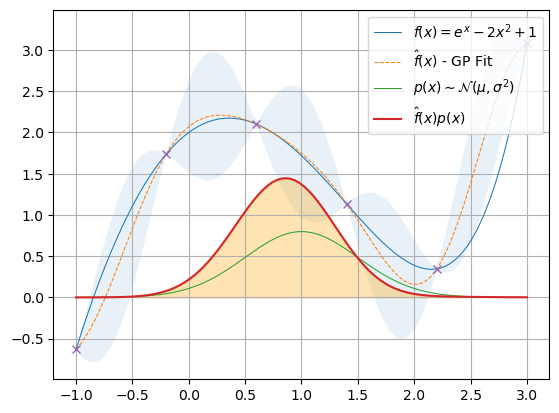

Eₚ[f(x)]: 1.580216884613037

Bayesian Quadrature
1 pts:
Estimate: 0.52026010 , StDev: 0.71392059
Absolute Error: 1.05995679

4 pts:
Estimate: 1.57770216 , StDev: 0.02666838
Absolute Error: 0.00251472

8 pts:
Estimate: 1.57746792 , StDev: 0.00404861
Absolute Error: 0.00274897

16 pts:
Estimate: 1.57917964 , StDev: 0.00122070
Absolute Error: 0.00103724

32 pts:
Estimate: 1.58356762 , StDev: 0.00000000
Absolute Error: 0.00335073



In [559]:
def f(x):
    return jnp.exp(x) - 2*x**2 + 1

def fp(x, mu, sigma):
    px = (1/(sigma*jnp.sqrt(2*jnp.pi)))*jnp.exp(-(x-mu)**2/(2*sigma**2))
    return f(x)*px

def FP(mu, sigma):
    t1 = jnp.exp(sigma**2/2 + mu)
    return t1 - 2*sigma**2 - 2*mu**2 + 1

#integral of f(x) from lower to upper
mu = 1
sigma = 0.5
true_value = FP(mu,sigma)

#kernel hyperparameters
s = 1
l = 0.5

#sample n points
n = 6
x = np.linspace(mu-4*sigma,mu+4*sigma,n)
y = f(x)



#points to plot gp
x_eval = np.linspace(mu-4*sigma,mu+4*sigma,100)
mu_eval,var_eval = gp_predict1d(x,y,x_eval,kernel=rbf1d,s=s,l=l)
sig_diag = np.sqrt(np.clip(np.diag(var_eval), 0.0, None))

#real curve
y1 = f(x_eval)
y2 = (1/(sigma*jnp.sqrt(2*jnp.pi)))*jnp.exp(-(x_eval-mu)**2/(2*sigma**2))
y3 = fp(x_eval,mu,sigma)


mask = (x_eval >= -0.5) & (x_eval <= 2.5)
points_fill = x_eval[mask]
y_fill = y3[mask]

#plot gp
plt.plot(x_eval,y1,label=r'$f(x) = e^x - 2x^2 + 1$', ls='-',lw=0.75)
plt.plot(x_eval, mu_eval, label=r'$\hat{f}(x)$ - GP Fit', ls='--', lw=0.75)
plt.plot(x_eval, y2, label=r'$p(x) \sim \mathcal{N}(\mu, \sigma^2)$', ls='-', lw=0.75)
plt.plot(x_eval,y3,label=r'$\hat{f}(x)p(x)$', ls='-')
plt.plot(x,y,'x')
plt.fill_between(x_eval,mu_eval-2*sig_diag,mu_eval+2*sig_diag,alpha=0.1)
plt.fill_between(points_fill, y_fill, color='orange', alpha=0.3) 
plt.legend()
plt.grid()
plt.show()


print(f"Eₚ[f(x)]: {true_value}")
print()
print("Bayesian Quadrature")
for n in [1,4,8,16,32]:
    x = np.linspace(mu-2*sigma,mu+2*sigma,n)
    y = f(x)
    I_mu, I_var = integrate_gaussian(x,y,s,l,mu,sigma)
    error = np.abs(true_value - I_mu)
    print(f"{n} pts:")
    print(f"Estimate: {I_mu:.8f} , StDev: {np.sqrt(I_var):.8f}")
    print(f"Absolute Error: {error:.8f}")
    print()

### Bimodal VBMC attempt

In [460]:
def plot_GP_surrogate(X, y, X_new, y_pred_mean, y_pred_std):
    plt.figure(figsize=(10, 6))

    plt.plot(X_new, y_pred_mean, lw=2, color='gray', label='GP Mean')
    plt.fill_between(X_new.ravel(),
                    y_pred_mean.ravel() - 2*y_pred_std.ravel(),
                    y_pred_mean.ravel() + 2*y_pred_std.ravel(),
                    color='lightgray', label='95% CI')


    plt.scatter(X, y, c='red', s=50, label='Observed')
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.title("Log GP Surrogate")
    plt.legend(loc='upper left')
    plt.tight_layout()


#In practice we wont know the the value of the parameter/s (obviously) and likelihoods will be difficult or expensive
def expensive_log_likelihood1(mu1,mu2,s1,s2,p1,p2,obs):
    gauss1 = 1/(jnp.sqrt(2*jnp.pi)*s1)*jnp.exp(-0.5*((obs - mu1)/s1)**2)
    gauss2 = 1/(jnp.sqrt(2*jnp.pi)*s2)*jnp.exp(-0.5*((obs - mu2)/s2)**2)
    

    likelihood = p1*gauss1 + p2*gauss2
    log_likelihood = np.log(likelihood + 1e-12)
    return log_likelihood

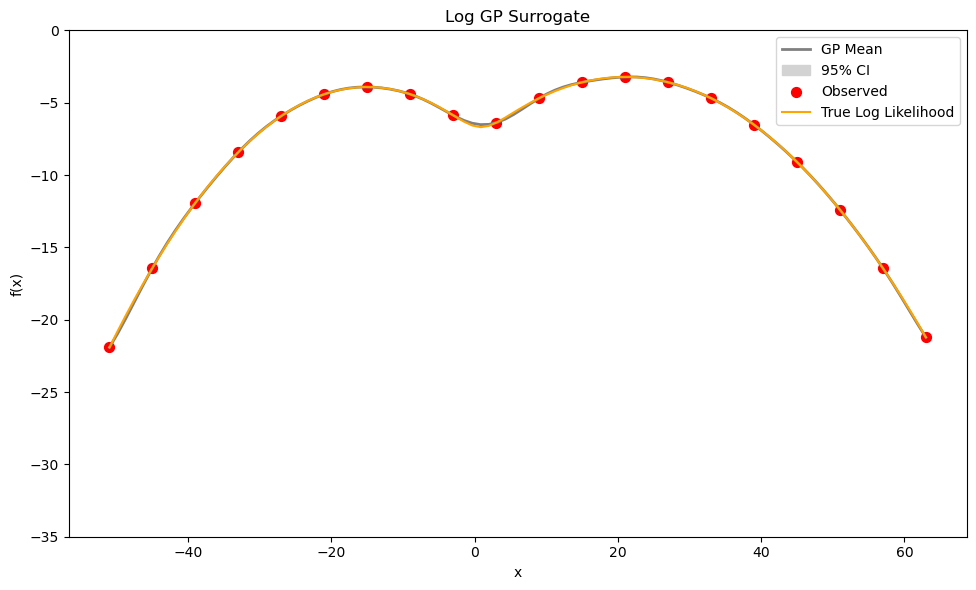

In [491]:
n = 20
mu1_true = -15
mu2_true = 21
sigma1_true= 6
sigma2_true = 7
p1_true = 0.3
p2_true = 1 - p1_true

lower = mu1_true - 6*sigma1_true
upper = mu2_true + 6*sigma2_true


x = np.linspace(lower,upper,n).reshape(-1,1)
y = expensive_log_likelihood1(mu1_true,mu2_true,
                             sigma1_true,sigma2_true,
                             p1_true, p2_true,
                             x.ravel()).reshape(-1,1)

#hyperparameters for gp
s = 2
l = 10

#plot gp
x_eval= jnp.linspace(lower,upper,100).reshape(-1,1)
mu_eval,var_eval = gp_predict1d(x,y,x_eval,kernel=rbf1d,s=s,l=l)
sig_diag = jnp.sqrt(np.diag(var_eval))

plot_GP_surrogate(x, y, x_eval, mu_eval, sig_diag)


x_vals = jnp.linspace(lower, upper, 100).ravel().reshape(-1,1)
log_likelihood = expensive_log_likelihood1(mu1_true,mu2_true,
                                          sigma1_true,sigma2_true,
                                          p1_true, p2_true,
                                          x_vals.ravel()).reshape(-1,1)

plt.plot(x_vals, log_likelihood, label='True Log Likelihood', color='orange')
plt.ylim(-35,0)
plt.legend()
plt.show()

### Find variational posterior

$$
\log p(\mathbf{x}) = \underbrace{\mathbb{E}_q[\log p(\mathbf{z},\mathbf{x})] - \mathbb{E}_q[\log q(\mathbf{z})]}_{= ELBO} + \underbrace{\text{KL}(q(\mathbf{z})||p(\mathbf{z}|\mathbf{x}))}_{\ge 0}
$$

$$
\text{ELBO} = \underbrace{\mathbb{E}_q[\log p(\mathbf{z},\mathbf{x})]}_{=\text{Expected Log Joint}} + \underbrace{\left(-\mathbb{E}_q[\log q(\mathbf{z})]\right)}_{=\text{Entropy of Q}}
$$


 In this example, the expensive likelihood function $p(\mathbf{z}|\mathbf{x}) = p(\mathbf{x},\mathbf{z})$.

 - $\mathbb{E}_q[\log p(\mathbf{z},\mathbf{x})] = \mathbb{E}_q[\log p(\mathbf{z}|\mathbf{x})]$
 - Maximum $\text{ELBO}$ occurs when $\text{KL}(q(\mathbf{z})||p(\mathbf{z}|\mathbf{x})) = 0 \implies q(\mathbf{z}) = p(\mathbf{z}|\mathbf{x})$
 - This makes $\mathbb{E}_q[\log p(\mathbf{z}|\mathbf{x})]$ the negative entropy of Q.
 - This makes the maximum $\text{ELBO} = 0$ 


 Another way to see this is since $p(\mathbf{x},\mathbf{z}) = p(\mathbf{z}|\mathbf{x})p(\mathbf{x})$
 - Maximum $\text{ELBO}$ occurs when $\text{KL}(q(\mathbf{z})||p(\mathbf{z}|\mathbf{x})) = 0$ 
 - $\implies \log p(\mathbf{x}) = \text{ELBO} + \underbrace{\text{KL}(q(\mathbf{z})||p(\mathbf{z}|\mathbf{x}))}_{= 0} = 0$ since $p(\mathbf{x}) = 1$   


In [462]:
#bimodal gaussian mixture pdf
def mixture_pdf1(x,mu1,mu2,s1,s2,p1,p2):
    term1 = 1/(jnp.sqrt(2*jnp.pi)*s1)*jnp.exp(-0.5*((x - mu1)/s1)**2)
    term2 = 1/(jnp.sqrt(2*jnp.pi)*s2)*jnp.exp(-0.5*((x - mu2)/s2)**2)
    return p1*term1 + p2*term2

#MC estimate of entropy of a bimodal gaussian
def entropy1(mu1,mu2,s1,s2,p1,p2, key=None, n_samples=25000):
    key1, key2 = jax.random.split(key)
    
    #sample from mixture
    mix = jax.random.choice(key1, jnp.array([0, 1]), shape=(n_samples,), p=jnp.array([p1, p2]))
    z = jax.random.normal(key2, shape=(n_samples,))
    samples = jnp.where(mix == 0, mu1 + s1*z, mu2 + s2*z)

    #compute pdf at sampled points
    pdf = mixture_pdf1(samples,mu1,mu2,s1,s2,p1,p2)

    #return entropy
    h = -jnp.log(pdf + 1e-12)
    return jnp.mean(h)

def log_joint1(x_eval, y_eval, sigma, l, mu1,mu2,s1,s2,p1,p2):
    x_eval = x_eval.reshape(-1,1)
    y_eval = y_eval.reshape(-1,1)
    
    #kernel matrix
    Kxx = rbf1d(x_eval, x_eval.T, sigma, l)
    Kxx += 1e-10*jnp.eye(len(Kxx))
    
    #cross-covariances
    kF1 = vk(x_eval, sigma, l, mu1, s1).reshape(-1,1)
    kF2 = vk(x_eval, sigma, l, mu2, s2).reshape(-1,1)
    kF = p1*kF1 + p2*kF2
    
    #posterior mean
    mu = kF.T@jnp.linalg.solve(Kxx, y_eval)
    return mu[0][0]


#ELBO computation for bimodal guassian
def elbo1(params,x,y,lower, upper, s=1, l=1, key=None):
    mu1,mu2,logs1,logs2,w1,w2 = params

    #ensure parameters are within reasonable bounds
    mu1 = jnp.clip(mu1, lower + 1e-2, upper - 1e-2)
    mu2 = jnp.clip(mu2, mu1, upper - 1e-2)

    s1 = jnp.exp(logs1)
    s2 = jnp.exp(logs2)

    upper_s1 = (mu1 - lower)/2.5
    lower_s1 = jnp.minimum(0.1, upper_s1)
    s1 = jnp.clip(s1, lower_s1, upper_s1)

    upper_s2 = (upper - mu2)/2.5
    lower_s2 = jnp.minimum(0.1, upper_s2)
    s2 = jnp.clip(s2, lower_s2, upper_s2)

    logits = jnp.array([w1, w2])
    p1,p2 = jax.nn.softmax(logits)

    #compute expected log joint
    #integral of log(p(x,z))*q(x)
    expected_log_joint = log_joint1(x,y,s,l,mu1,mu2,s1,s2,p1,p2)

    #entropy of Gaussian q
    entropy_q = entropy1(mu1,mu2,s1,s2,p1,p2, key=key)

    #return elbo
    return -expected_log_joint - entropy_q


In [508]:
mu1_initial = -12
mu2_initial = 23
s1_initial = 6
s2_initial = 7
w1_initial = 10
w2_initial = 10

params = jnp.array([mu1_initial, mu2_initial,
                    jnp.log(s1_initial), jnp.log(s2_initial),
                    w1_initial, w2_initial])
grad_elbo = jax.jit(jax.grad(elbo1))

best_elbo = -jnp.inf
best_params = params.copy()

key = jax.random.PRNGKey(0)
lr = 0.001

start = time.time()
for i in range(10000):
    key, subkey = jax.random.split(key)
    grads = grad_elbo(params,x,y,lower,upper,s,l, key=subkey)
    params = params - lr*grads

    if (i+1) % 1000 == 0:
        current_elbo = -elbo1(params,x,y,lower,upper,s,l, key=subkey)
        if current_elbo > best_elbo:
            best_elbo = current_elbo
            best_params = params.copy()
        print(f"Iter {i+1}: ELBO = {current_elbo}")
 
params = best_params
mu1_opt = params[0]
mu2_opt = params[1]

s1_opt = params[2]
s2_opt = params[3]
s1_opt = jnp.exp(s1_opt)
s2_opt = jnp.exp(s2_opt)

logits = jnp.array([params[4], params[5]])
p1_opt,p2_opt = jax.nn.softmax(logits) 

params = ["mu1", "mu2", "sigma1", "sigma2", "p1", "p2"]
optimized = [mu1_opt, mu2_opt, s1_opt, s2_opt, p1_opt, p2_opt]
true_vals = [mu1_true, mu2_true, sigma1_true, sigma2_true, p1_true, p2_true]


print()
print("Best ELBO", best_elbo)
print(f"{'Parameter':<10} {'Optimized':>12} {'True':>12}")
print("-"*36)
for name, opt, true in zip(params, optimized, true_vals):
    print(f"{name:<10} {opt:12.4f} {true:12.4f}")


end = time.time()
print()
print(f"Time taken: {end - start:.2f} seconds")

Iter 1000: ELBO = -0.08806586265563965
Iter 2000: ELBO = -0.05666351318359375
Iter 3000: ELBO = -0.06805729866027832
Iter 4000: ELBO = -0.06114506721496582
Iter 5000: ELBO = -0.08353757858276367
Iter 6000: ELBO = -0.11833834648132324
Iter 7000: ELBO = -0.1324164867401123
Iter 8000: ELBO = -0.1658177375793457
Iter 9000: ELBO = -0.1621403694152832
Iter 10000: ELBO = -0.17717289924621582

Best ELBO -0.056663513
Parameter     Optimized         True
------------------------------------
mu1            -12.0517     -15.0000
mu2             22.9561      21.0000
sigma1           6.6245       6.0000
sigma2           6.8199       7.0000
p1               0.3189       0.3000
p2               0.6811       0.7000

Time taken: 16.97 seconds


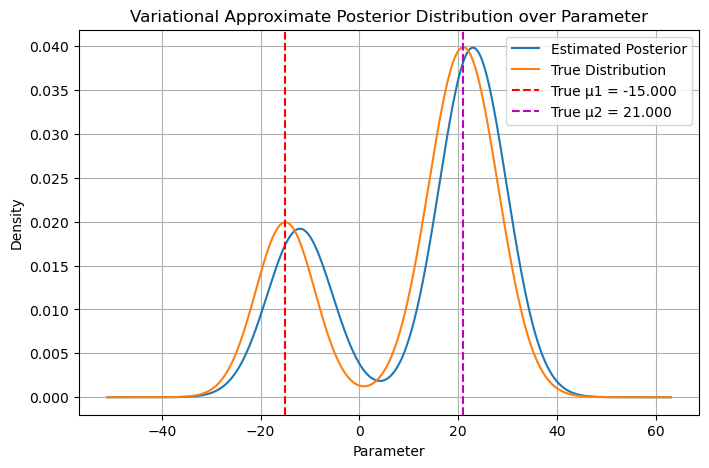

In [509]:
#plot range
x_min = lower
x_max = upper
x_vals = jnp.linspace(x_min, x_max, 1000)

#estimated mixture PDF
pdf_vals = mixture_pdf1(x_vals,mu1_opt,mu2_opt,s1_opt,s2_opt, p1_opt, p2_opt)

#true mixture PDF
true_vals = mixture_pdf1(x_vals,mu1_true,mu2_true,sigma1_true,sigma2_true, p1_true, p2_true)

#compare estimated and true distributions
plt.figure(figsize=(8,5))
plt.plot(x_vals, pdf_vals, label='Estimated Posterior')
plt.plot(x_vals, true_vals, label='True Distribution')
plt.axvline(mu1_true, color='r', linestyle='--', label=f'True μ1 = {mu1_true:.3f}')
plt.axvline(mu2_true, color='m', linestyle='--', label=f'True μ2 = {mu2_true:.3f}')
plt.title('Variational Approximate Posterior Distribution over Parameter')
plt.xlabel('Parameter')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()



### Trimodal VBMC attempt

In [ ]:
#In practice we wont know the the value of the parameter/s (obviously) and likelihoods will be difficult or expensive
def expensive_log_likelihood2(mu1,mu2,mu3,s1,s2,s3,obs):
    gauss1 = 1/(jnp.sqrt(2*jnp.pi)*s1)*jnp.exp(-0.5*((obs - mu1)/s1)**2)
    gauss2 = 1/(jnp.sqrt(2*jnp.pi)*s2)*jnp.exp(-0.5*((obs - mu2)/s2)**2)
    gauss3 = 1/(jnp.sqrt(2*jnp.pi)*s3)*jnp.exp(-0.5*((obs - mu3)/s3)**2)
    

    likelihood = 1/3*gauss1 + 1/3*gauss2 + 1/3*gauss3 
    log_likelihood = np.log(likelihood + 1e-12)
    return log_likelihood

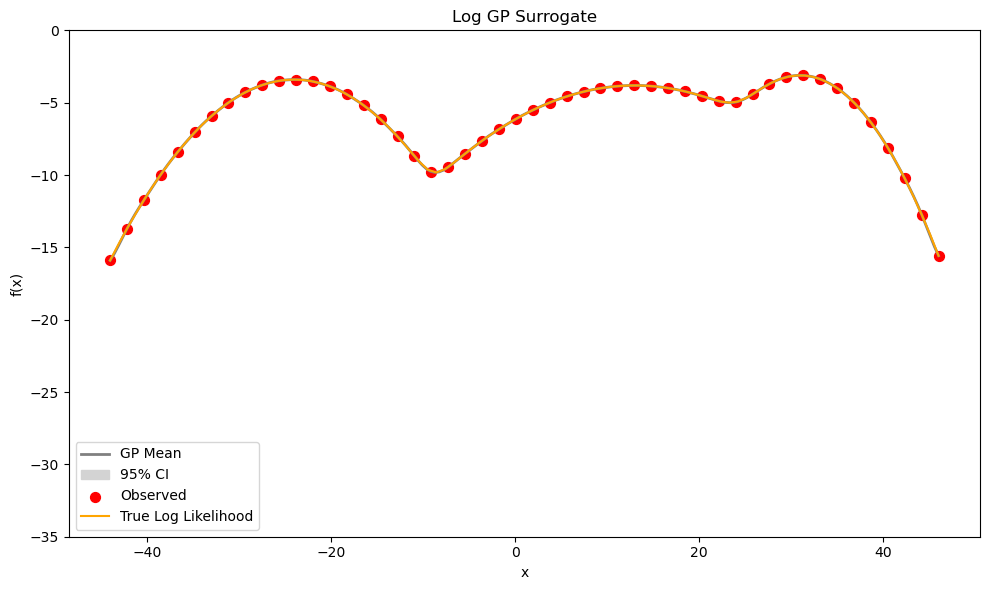

In [539]:
n = 50
mu1_true = -24
mu2_true = 13
mu3_true = 31
sigma1_true= 4
sigma2_true = 6
sigma3_true = 3

lower = mu1_true - 5*sigma1_true
upper = mu3_true + 5*sigma3_true


#vbmc traditionally samples much smarter than randomly but here we sample 3 random points and infer a likelihood
x = np.linspace(lower,upper,n).reshape(-1,1)
y = expensive_log_likelihood2(mu1_true,mu2_true,mu3_true,
                             sigma1_true,sigma2_true,sigma3_true,
                             x.ravel()).reshape(-1,1)

#hyperparameters for gp
s = 1
l = 3

#plot gp
x_eval= jnp.linspace(lower,upper,200).reshape(-1,1)
mu_eval,var_eval = gp_predict1d(x,y,x_eval,kernel=rbf1d,s=s,l=l)
sig_diag = jnp.sqrt(np.diag(var_eval))

plot_GP_surrogate(x, y, x_eval, mu_eval, sig_diag)


x_vals = jnp.linspace(lower, upper, 100).ravel().reshape(-1,1)
log_likelihood = expensive_log_likelihood2(mu1_true,mu2_true,mu3_true,
                                          sigma1_true,sigma2_true,sigma3_true,
                                          x_vals.ravel()).reshape(-1,1)

plt.plot(x_vals, log_likelihood, label='True Log Likelihood', color='orange')
plt.ylim(-35,0)
plt.legend()
plt.show()

### Find variational posterior

$$
\log p(\mathbf{x}) = \underbrace{\mathbb{E}_q[\log p(\mathbf{z},\mathbf{x})] - \mathbb{E}_q[\log q(\mathbf{z})]}_{= ELBO} + \underbrace{\text{KL}(q(\mathbf{z})||p(\mathbf{z}|\mathbf{x}))}_{\ge 0}
$$

$$
\text{ELBO} = \underbrace{\mathbb{E}_q[\log p(\mathbf{z},\mathbf{x})]}_{=\text{Expected Log Joint}} + \underbrace{\left(-\mathbb{E}_q[\log q(\mathbf{z})]\right)}_{=\text{Entropy of Q}}
$$


 In this example, the expensive likelihood function $p(\mathbf{z}|\mathbf{x}) = p(\mathbf{x},\mathbf{z})$.

 - $\mathbb{E}_q[\log p(\mathbf{z},\mathbf{x})] = \mathbb{E}_q[\log p(\mathbf{z}|\mathbf{x})]$
 - Maximum $\text{ELBO}$ occurs when $\text{KL}(q(\mathbf{z})||p(\mathbf{z}|\mathbf{x})) = 0 \implies q(\mathbf{z}) = p(\mathbf{z}|\mathbf{x})$
 - This makes $\mathbb{E}_q[\log p(\mathbf{z}|\mathbf{x})]$ the negative entropy of Q.
 - This makes the maximum $\text{ELBO} = 0$ 


 Another way to see this is since $p(\mathbf{x},\mathbf{z}) = p(\mathbf{z}|\mathbf{x})p(\mathbf{x})$
 - Maximum $\text{ELBO}$ occurs when $\text{KL}(q(\mathbf{z})||p(\mathbf{z}|\mathbf{x})) = 0$ 
 - $\implies \log p(\mathbf{x}) = \text{ELBO} + \underbrace{\text{KL}(q(\mathbf{z})||p(\mathbf{z}|\mathbf{x}))}_{= 0} = 0$ since $p(\mathbf{x}) = 1$   


In [517]:
#trimodal gaussian mixture pdf
def mixture_pdf2(x,mu1,mu2,mu3,s1,s2,s3):
    term1 = 1/(jnp.sqrt(2*jnp.pi)*s1)*jnp.exp(-0.5*((x - mu1)/s1)**2)
    term2 = 1/(jnp.sqrt(2*jnp.pi)*s2)*jnp.exp(-0.5*((x - mu2)/s2)**2)
    term3 = 1/(jnp.sqrt(2*jnp.pi)*s3)*jnp.exp(-0.5*((x - mu3)/s3)**2)
    return 1/3*term1 + 1/3*term2 + 1/3*term3

#MC estimate of entropy of a trimodal gaussian
def entropy2(mu1,mu2,mu3,s1,s2,s3, key=None, n_samples=100000):
    key1, key2 = jax.random.split(key)
    
    #sample from mixture
    mix = jax.random.choice(key1, jnp.array([0, 1, 2]), shape=(n_samples,))
    z = jax.random.normal(key2, shape=(n_samples,))
    samples = jnp.where(mix == 0, mu1 + s1*z, 
              jnp.where(mix == 1, mu2 + s2*z, 
                                  mu3 + s3*z))

    #compute pdf at sampled points
    pdf = mixture_pdf2(samples,mu1,mu2,mu3,s1,s2,s3)

    #return entropy
    h = -jnp.log(pdf + 1e-12)
    return jnp.mean(h)

def log_joint2(x_eval, y_eval, sigma, l, mu1,mu2,mu3,s1,s2,s3):
    x_eval = x_eval.reshape(-1,1)
    y_eval = y_eval.reshape(-1,1)
    
    #kernel matrix
    Kxx = rbf1d(x_eval, x_eval.T, sigma, l)
    Kxx += 1e-10*jnp.eye(len(Kxx))
    
    #cross-covariances
    kF1 = vk(x_eval, sigma, l, mu1, s1).reshape(-1,1)
    kF2 = vk(x_eval, sigma, l, mu2, s2).reshape(-1,1)
    kF3 = vk(x_eval, sigma, l, mu3, s3).reshape(-1,1)
    kF = 1/3*kF1 + 1/3*kF2 + 1/3*kF3
    
    #posterior mean
    mu = kF.T@jnp.linalg.solve(Kxx, y_eval)
    return mu[0][0]


#ELBO computation for trimodal guassian
def elbo2(params, x, y, lower, upper, s=1, l=1, key=None):
    mu1,mu2,mu3,s1,s2,s3 = params

    #ensure parameters are within reasonable bounds
    #mu parameters must be within gp hypersurface
    mu1 = jnp.clip(mu1, lower + 1e-2, upper - 1e-2)
    mu2 = jnp.clip(mu2, mu1, upper - 1e-2)
    mu3 = jnp.clip(mu3, mu2, upper - 1e-2)
    
    #s parameters must ensure that most of the density of q falls in the domain of the gp hypersurface
    s1 = jnp.exp(s1)
    upper_s1 = (mu1 - lower)/2.5 
    lower_s1 = jnp.minimum(0.1, upper_s1)
    s1 = jnp.clip(s1, lower_s1, upper_s1)

    s2 = jnp.exp(s2)
    upper_s2 = (upper - mu2)/2.5
    lower_s2 = jnp.minimum(0.1, upper_s2)
    s2 = jnp.clip(s2, lower_s2, upper_s2)

    s3 = jnp.exp(s3)
    upper_s3 = (upper - mu3)/2.5
    lower_s3 = jnp.minimum(0.1, upper_s3)
    s3 = jnp.clip(s3, lower_s3, upper_s3)


    #compute expected log joint
    #integral of log(p(x,z))*q(x)
    expected_log_joint = log_joint2(x, y, s, l, mu1,mu2,mu3,s1,s2,s3)

    #entropy of Gaussian q
    entropy_q = entropy2(mu1,mu2,mu3,s1,s2,s3, key=key)

    #return elbo
    return -expected_log_joint - entropy_q

Iter 500: ELBO = -0.5155901908874512
Iter 1000: ELBO = -0.4936981201171875
Iter 1500: ELBO = -0.46974658966064453
Iter 2000: ELBO = -0.4363412857055664
Iter 2500: ELBO = -0.3852829933166504
Iter 3000: ELBO = -0.2825756072998047
Iter 3500: ELBO = -0.1935100555419922
Iter 4000: ELBO = -0.1298534870147705
Iter 4500: ELBO = -0.08863496780395508
Iter 5000: ELBO = -0.05870556831359863
Iter 5500: ELBO = -0.039354562759399414
Iter 6000: ELBO = -0.0313723087310791
Iter 6500: ELBO = -0.022242069244384766
Iter 7000: ELBO = -0.011806011199951172
Iter 7500: ELBO = -0.011783123016357422
Iter 8000: ELBO = -0.004801034927368164
Iter 8500: ELBO = -0.00656890869140625
Iter 9000: ELBO = -0.0051004886627197266
Iter 9500: ELBO = -0.0008487701416015625
Iter 10000: ELBO = -0.0025713443756103516

Best ELBO -0.00084877014
Parameter     Optimized         True
------------------------------------
mu1            -23.6438     -24.0000
mu2             12.3541      13.0000
mu3             30.9058      31.0000
sigma1

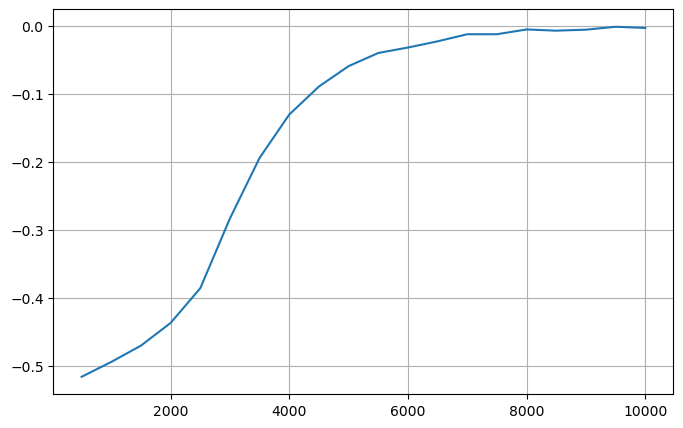


Time taken: 44.57 seconds


In [545]:

#initial values
mu1_initial = -15
mu2_initial = 10
mu3_initial = 30
s1_initial = 2
s2_initial = 7
s3_initial = 4
params = jnp.array([mu1_initial, mu2_initial, mu3_initial,
                    jnp.log(s1_initial), jnp.log(s2_initial), jnp.log(s3_initial)])

grad_elbo = jax.jit(jax.grad(elbo2))

best_elbo = -jnp.inf
best_params = params.copy()

key = jax.random.PRNGKey(0)
lr = 0.02
elbo_history = []
iter_history = []
start = time.time()
for i in range(10000):
    key, subkey = jax.random.split(key)
    grads = grad_elbo(params,x,y,lower,upper,s,l, key=key)
    params = params - lr*grads

    if (i+1) % 500 == 0:
        current_elbo = -elbo2(params,x,y,lower,upper,s,l, key=key)
        elbo_history.append(current_elbo)
        iter_history.append(i+1)
        if current_elbo > best_elbo:
            best_elbo = current_elbo
            best_params = params.copy()
        print(f"Iter {i+1}: ELBO = {current_elbo}")
 
params = best_params
mu1_opt = params[0]
mu2_opt = params[1]
mu3_opt = params[2]

s1_opt = params[3]
s2_opt = params[4]
s3_opt = params[5]

s1_opt = jnp.exp(s1_opt)
s2_opt = jnp.exp(s2_opt)
s3_opt = jnp.exp(s3_opt)

params = ["mu1", "mu2", "mu3", "sigma1", "sigma2", "sigma3"]
optimized = [mu1_opt, mu2_opt, mu3_opt, s1_opt, s2_opt, s3_opt]
true_vals = [mu1_true, mu2_true, mu3_true, sigma1_true, sigma2_true, sigma3_true]


print()
print("Best ELBO", best_elbo)
print(f"{'Parameter':<10} {'Optimized':>12} {'True':>12}")
print("-"*36)
for name, opt, true in zip(params, optimized, true_vals):
    print(f"{name:<10} {opt:12.4f} {true:12.4f}")

plt.figure(figsize=(8,5))
plt.plot(iter_history, elbo_history)
plt.grid(True)
plt.show()
end = time.time()
print()
print(f"Time taken: {end - start:.2f} seconds")


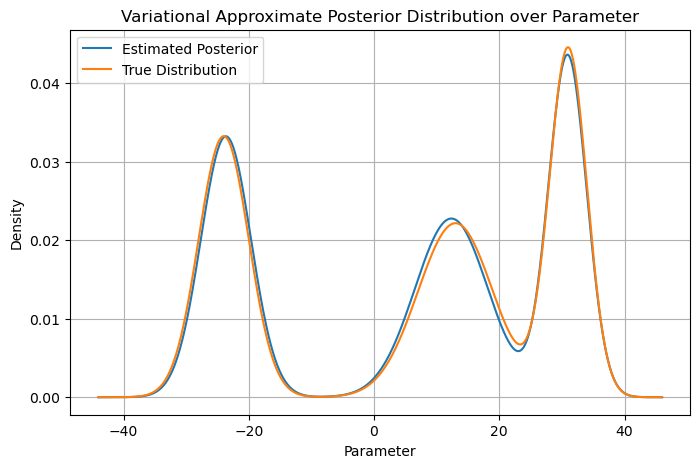

In [546]:
#plot range
x_min = lower
x_max = upper
x_vals = jnp.linspace(x_min, x_max, 1000)

#estimated mixture PDF
pdf_vals = mixture_pdf2(x_vals,mu1_opt,mu2_opt,mu3_opt,s1_opt,s2_opt,s3_opt)

#true mixture PDF
true_vals = mixture_pdf2(x_vals,mu1_true,mu2_true,mu3_true,sigma1_true,sigma2_true,sigma3_true)

#compare estimated and true distributions
plt.figure(figsize=(8,5))
plt.plot(x_vals, pdf_vals, label='Estimated Posterior')
plt.plot(x_vals, true_vals, label='True Distribution')
# plt.axvline(mu1_true, color='r', linestyle='--', label=f'True μ1 = {mu1_true:.3f}')
# plt.axvline(mu2_true, color='m', linestyle='--', label=f'True μ2 = {mu2_true:.3f}')
# plt.axvline(mu3_true, color='b', linestyle='--', label=f'True μ3 = {mu3_true:.3f}')
plt.title('Variational Approximate Posterior Distribution over Parameter')
plt.xlabel('Parameter')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

## Bayesian Quadrature
### Integrating f(t)p(t) - univariate case


---

We have:
$$
\boxed{\mathbb{E}_{f|\mathbf{D}}[F(x)] = M(x) + \mathbf{k}_F^T(x) K^{-1} \Big(f(X)-m(X) \Big)}
$$

$$
\boxed{\text{Cov}_{f|\mathbf{D}}\left(F(x), F(x')\right) = K(x,x') - \mathbf{k}_F^T(x) K^{-1} \mathbf{k}_F(x')}
$$


where $$\textbf{k}_F(x) = \Big[ \int_a^x k(t, x_1)p(t)dt,\, \int_a^x k(t, x_2)p(t)dt,\, \cdots ,\, \int_a^x k(t, x_n)p(t)dt \Big]$$

and $K = k(X,X)$ is the Gram matrix of the training inputs under the kernel k.

---

### Integrating f(x)p(x)

Lets start by deriving the mean of the integral

Later we will use different length scales in each dimension for Automatic Relevance Determination (ARD)

$$
k(\mathbf{y}, \mathbf{x}) = \sigma_f^2 \exp\Big[-\frac{1}{2} (\mathbf{x}-\mathbf{y})^\top \mathbf{L}^{-2} (\mathbf{x}-\mathbf{y}) \Big],
$$

where $\mathbf{L}^{-2} = \mathrm{diag}(l_1^{-2}, \dots, l_d^{-2})$.


For now, we use RBF isotropic kernel $k(\mathbf{y},\mathbf{x}) = \sigma_f^2\exp \left(-\frac{1}{2l^2} ||\mathbf{x}-\mathbf{y}||^2 \right)$:



$$
\begin{aligned}
v[k] &= \int k(\mathbf{t},\mathbf{s})p(\mathbf{t}) d\mathbf{t} \\ 
     &= \int \sigma_f^2\exp \left(-\frac{1}{2l^2} ||\mathbf{s}-\mathbf{t}||^2 \right) \frac{1}{\sqrt{(2\pi)^d |\Sigma_p|}} \exp\Big[-\frac{1}{2} (\mathbf{t}-\boldsymbol{\mu}_p)^\top \Sigma_p^{-1} (\mathbf{t}-\boldsymbol{\mu}_p)\Big] d\mathbf{t} \\
     &= \sigma_f^2 \sqrt{(2\pi)^d |l^2 I|} \int \frac{1}{\sqrt{(2\pi)^d |l^2 I|}} \exp \left(-\frac{1}{2l^2} ||\mathbf{s}-\mathbf{t}||^2 \right) \frac{1}{\sqrt{(2\pi)^d |\Sigma_p|}} \exp\Big[-\frac{1}{2} (\mathbf{t}-\boldsymbol{\mu}_p)^\top \Sigma_p^{-1} (\mathbf{t}-\boldsymbol{\mu}_p)\Big] d\mathbf{t} \\
     &= \sigma_f^2 (2\pi l^2)^{d/2} \int \mathcal{N}(\mathbf{t} \mid \mathbf{s}, l^2 I) \, \mathcal{N}(\mathbf{t} \mid \boldsymbol{\mu}_p, \Sigma_p) \, d\mathbf{t}.
\end{aligned}
$$

Using result A.7 in *Carl Edward Rasmussen & Christopher K. I. Williams (2006)*:

The product of two Gaussians gives another (un-normalized) Gaussian
$$
\mathcal{N}(x | a, A)\,\mathcal{N}(x | b, B)
= Z^{-1}\,\mathcal{N}(x | c, C)
$$
where
$$
\mathbf{c} = \mathbf{C}\,(A^{-1}a + B^{-1}b), 
\qquad 
C = \left(A^{-1} + B^{-1}\right)^{-1}
$$

The normalizing constant looks itself like a Gaussian

$$
Z^{-1} = (2\pi)^{-D/2} \, |A + B|^{-1/2} \, 
\exp\left(-\tfrac{1}{2}(a-b)^T(A+B)^{-1}(a-b)\right)
$$

Applying the result:
$$
\mathbf{C} = \Big((l^2 I)^{-1} + \Sigma_p^{-1}\Big)^{-1} = \Big(\frac{1}{l^2} I + \Sigma_p^{-1}\Big)^{-1}
$$

$$
\mathbf{c} = \mathbf{C} \Big((l^2 I)^{-1} \mathbf{s} + \Sigma_p^{-1} \boldsymbol{\mu}_p \Big)
$$

$$
Z^{-1} = (2\pi)^{-d/2} |\Sigma_p + l^2 I|^{-1/2} \exp\Big[-\frac{1}{2} (\mathbf{s}-\boldsymbol{\mu}_p)^T (\Sigma_p + l^2 I)^{-1} (\mathbf{s}-\boldsymbol{\mu}_p) \Big]
$$


The integral of a normalized Gaussian over all $\mathbf{t}$ is 1. So only the normalization constant is necessary:

$$
\begin{aligned}
v[k] &= \sigma_f^2 (2\pi l^2)^{d/2} Z^{-1} \\
     &= \sigma_f^2 (2\pi l^2)^{d/2} (2\pi)^{-d/2} |\Sigma_p + l^2 I|^{-1/2} \exp\Big[-\frac{1}{2} (\mathbf{s}-\boldsymbol{\mu}_p)^T (\Sigma_p + l^2 I)^{-1} (\mathbf{s}-\boldsymbol{\mu}_p) \Big] \\
     &= \sigma_f^2 l^{d} |\Sigma_p + l^2 I|^{-1/2} \exp\Big[-\frac{1}{2} (\mathbf{s}-\boldsymbol{\mu}_p)^T (\Sigma_p + l^2 I)^{-1} (\mathbf{s}-\boldsymbol{\mu}_p) \Big] \\
\end{aligned}
$$
---



For the uncertainty we have to integrate again. We will again use $[a,x] = [-\infty, \infty]$.


$$
\begin{aligned}
vv[k] &= \int \int k(t,s)p(t)p(s) dtds \\
      &= \int \Big[\int k(t,s)p(t) dt\Big] \,p(s)ds \\
      &= \int v[k] \,p(s)ds \\
\end{aligned}
$$

---

So we have:

$$
\boxed{\mathbb{E}_{f|\mathbf{D}}[F(x)] = M(x) + \mathbf{k}_F^T(x) K^{-1} \Big(f(X)-m(X) \Big)}
$$

$$
\boxed{\text{Cov}_{f|\mathbf{D}}\left(F(x), F(x')\right) = K(x,x') - \mathbf{k}_F^T(x) K^{-1} \mathbf{k}_F(x')}
$$

$$
\boxed{v[k] = \sigma_f^2 l^d |\Sigma_p + l^2 I|^{-1/2} \exp\Big[-\frac{1}{2} (\mathbf{s}-\boldsymbol{\mu}_p)^T (\Sigma_p + l^2 I)^{-1} (\mathbf{s}-\boldsymbol{\mu}_p) \Big]}
$$

$$
\boxed{vv[k] = }
$$

In [ ]:
def vk(input, sigmaf, l, mu_p, S_p):
    d = len(input)
    t1 = l**d/jnp.sqrt(jnp.linalg.det(S_p + l**2*jnp.eye(d)))
    t2 = jnp.exp(-0.5*(input - mu_p).T@jnp.linalg.inv(S_p + l**2*jnp.eye(d))@(input - mu_p))
    return sigmaf**2*t1*t2


# def vvk(sigma,l,s_q):
#     return 

def rbfnd(X1, X2, l=2.0, s=1.0):

    X1 = jnp.atleast_2d(X1).astype(jnp.float64)
    X2 = jnp.atleast_2d(X2).astype(jnp.float64)
    
    diff = X1[:, None, :] - X2[None, :, :]
    sqdist = jnp.sum(diff**2, axis=2)
    return s**2*jnp.exp(-0.5/l**2*sqdist)

def integrate_gaussian(x_eval, y_eval, sigmaf, l, mu_p, S_p):
    x_eval = x_eval.reshape(-1,1)
    y_eval = y_eval.reshape(-1,1)
    
    #kernel matrix
    Kxx = rbfnd(x_eval, x_eval.T, sigmaf, l)
    Kxx += 1e-10*jnp.eye(len(Kxx))
    
    #cross-covariances
    kF = vk(x_eval, sigmaf, l, mu_p, S_p).reshape(-1,1)
    #vF = vvk(sigma, l, s_p)
    
    #posterior mean and variance
    mu = (kF.T@jnp.linalg.solve(Kxx, y_eval)).item()
    #var = vF - (kF.T@jnp.linalg.solve(Kxx, kF)).item()
    #var = max(var, 0.0)
    
    return mu#, var